# Assignment: Risk predicition of criminal re-offense



**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to young offenders in Catalonia. 

SAVRY is a risk assessment tool, that supports structured professional judgement. SAVRY contains 24 risk factors, in which each item (variables `V65*` to `V88*`) can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points. 

+ Human score: There is also a score by a professional (variable `V56_@R1_resum_risc_global_reverse`) that can be low, moderate, or high. 
+ Recividism: In this dataset, there is information about whether people committed a new crime after the evaluation.  The variable `V115_reincidencia_2015` represents Recidivism (year 2015).
+ The variable `V60_SAVRY_total_score` contains a sum of scores in the risk items of SAVRY. This score can be seen as a baseline automatic method.

Features values can be found in ``reincidenciaJusticiaMenors.xlsx``. The description of features can be found in ``recidivismJuvenileJustice_variables_EN.pdf``. The data file we use is a subset of data obtained by the Centre d'Estudis Jurídics i Formació Especialitzada of the Catalan government and released in 2017.

The objectives of this assignment are: 
+ To compare the performance of SAVRY and ML-based methods, in terms of both performace and fairness metrics. 
+ To analyze the causes of unfairness.
+ To explore a mitigation strategy.

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [114]:
FILENAME_DATASET = 'reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [115]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [116]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

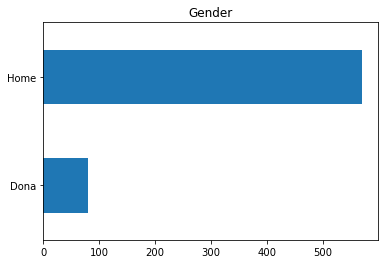

In [117]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

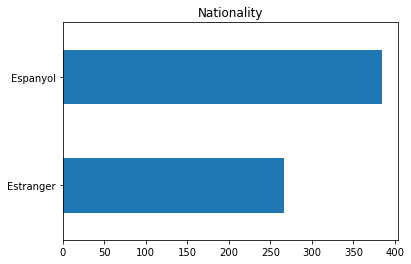

In [118]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

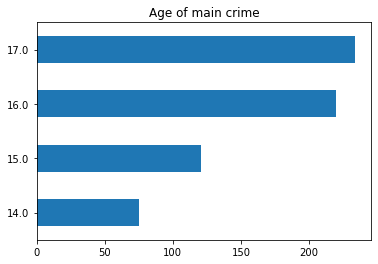

In [119]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

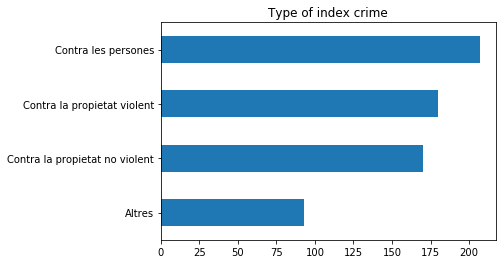

In [120]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

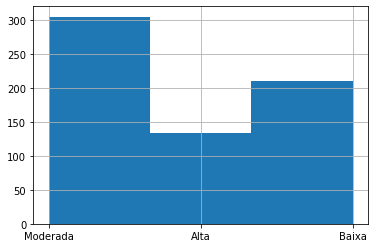

In [121]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

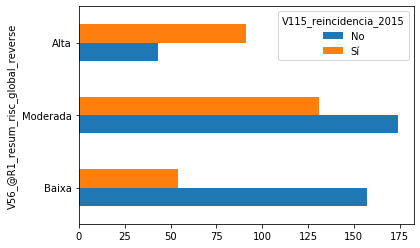

In [122]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [123]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015,No,Sí,recidivism_rate
V56_@R1_resum_risc_global_reverse,,,
Baixa,157,54,0.255924
Moderada,174,131,0.429508
Alta,43,91,0.679104


### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [124]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [125]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

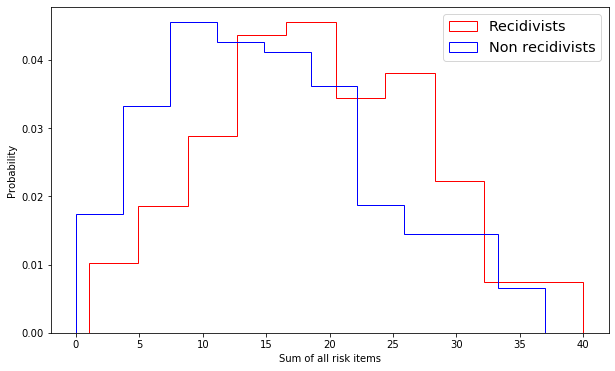

In [126]:
## baselin score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [127]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

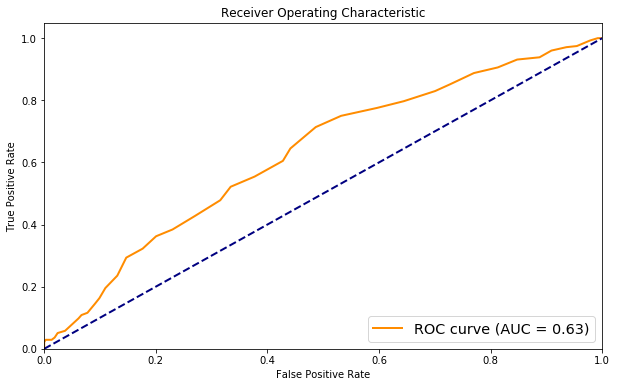

In [128]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [129]:
train, test = train_test_split(df, test_size=0.33)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [130]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [131]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [132]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

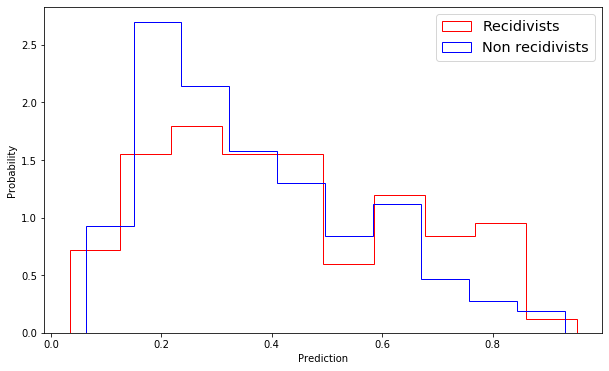

In [133]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

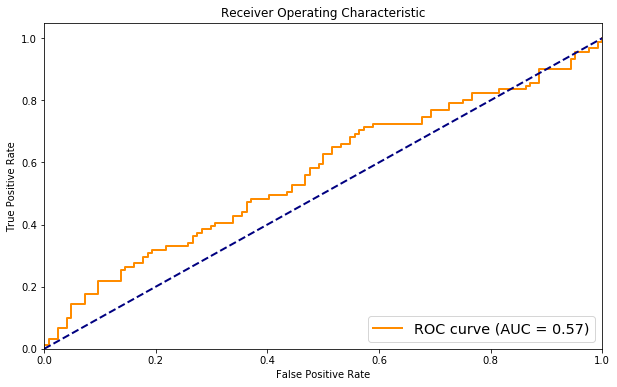

In [134]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [135]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [136]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [137]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

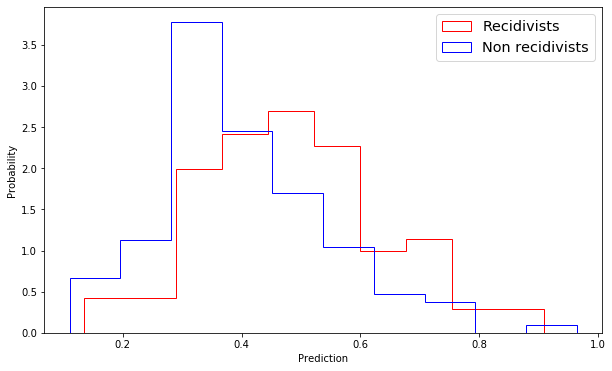

In [138]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

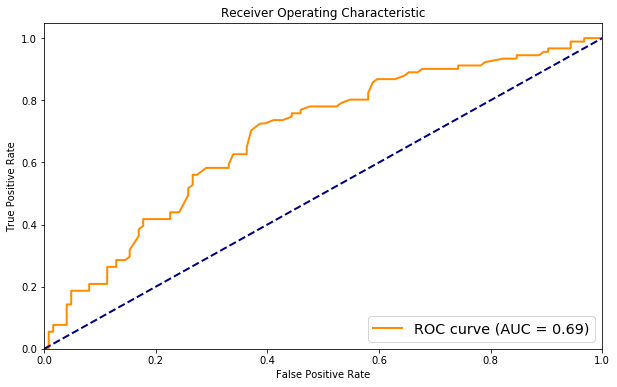

In [139]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [140]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [141]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [142]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

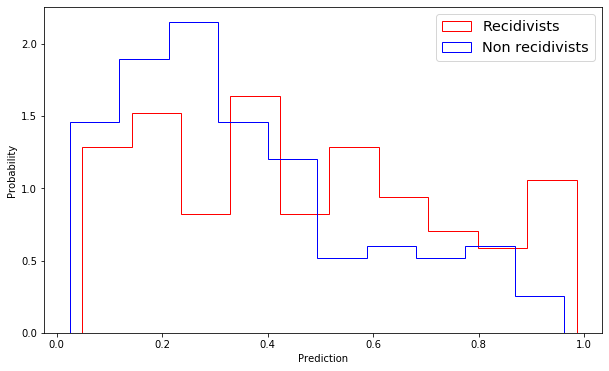

In [143]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

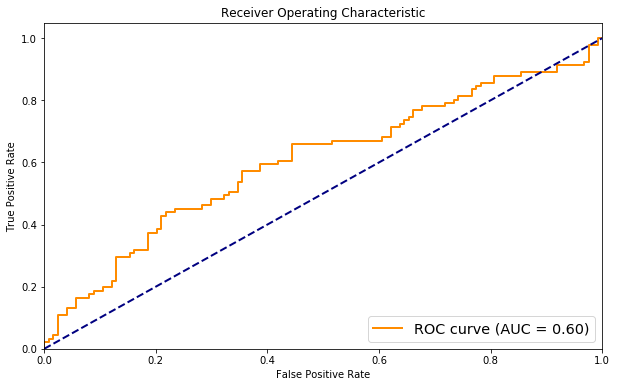

In [144]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [145]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe,Dona,Home
V115_reincidencia_2015,,
No,0.759494,0.549912
Sí,0.240506,0.450088


In [146]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger,Espanyol,Estranger
V115_reincidencia_2015,,
No,0.632812,0.492481
Sí,0.367188,0.507519


# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [147]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe,Dona,Home
V56_@R1_resum_risc_global_reverse,,
Alta,0.116667,0.114650
Baixa,0.433333,0.417197
Moderada,0.450000,0.468153


In [148]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger,Espanyol,Estranger
V56_@R1_resum_risc_global_reverse,,
Alta,0.106996,0.129771
Baixa,0.423868,0.412214
Moderada,0.469136,0.458015


## Overall SAVRY score and fairness

In [149]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 15.38
Average SAVRY score of women non-recidivist: 15.67


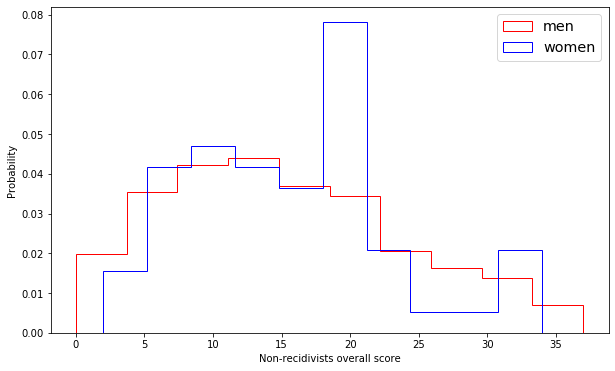

In [150]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [151]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 14.84
Average SAVRY score of foreigner non-recidivist: 16.51


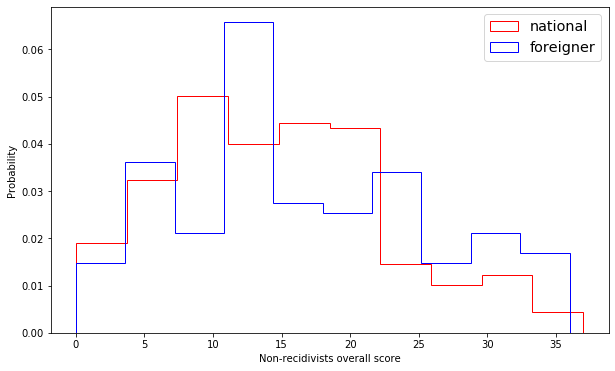

In [152]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score

In [153]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.43
Average predicted probability of women non-recidivist: 0.20


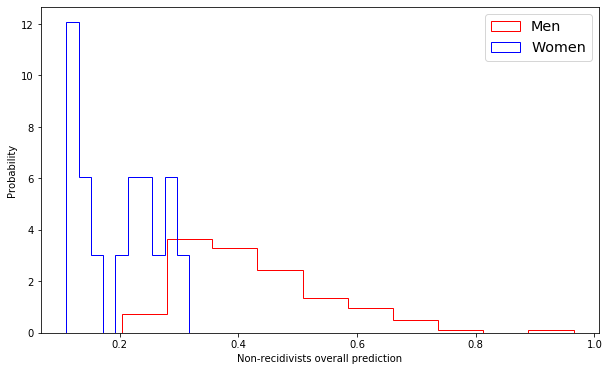

In [154]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [155]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.34
Average predicted probability of foreigner non-recidivist: 0.48


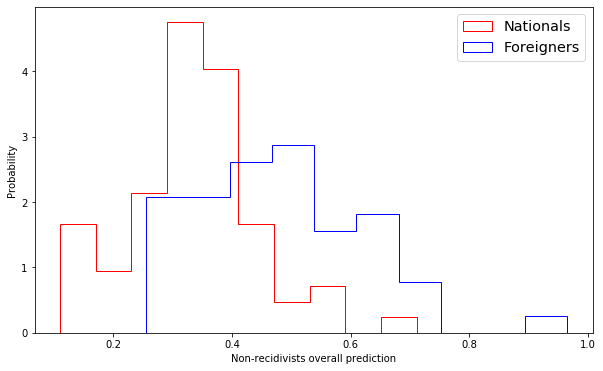

In [156]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 
2. Check if they satisfy the proposed fairness criteria. 
3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 


2. Is this method better than human experts in terms of fairness?


3. Which is the most suited fairness criterium for this problem? Why?


4. What are your conclusion about the use of a ML model to predict recividism?



#### Solution

**1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model.**

In [157]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

import random

random.seed(43)


In [158]:
train, test = train_test_split(df, test_size=0.33)

In [159]:
train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [160]:
models = [LogisticRegression(solver='liblinear'), SVC(probability=True), 
          KNeighborsClassifier(),DecisionTreeClassifier(),
          RandomForestClassifier(),GaussianProcessClassifier(kernel=Matern()),
          AdaBoostClassifier(), GaussianNB(),  SGDClassifier(loss="log")]
names = ["Logistic Regression", "Support Vector Machines",
         "K-Neighbors", "Decision Tree",
         "Random Forest", "Gaussian Process",
         "Ada Boost", "Gaussian Naive Bayes", "SGD"]

probabilities = {}

for model, name in zip(models, names):
    model.fit(train_X, train_y)
    probabilities[name] = model.predict_proba(test_X)[:,1] #store the probability of recividism
    
model.classes_


array(['No', 'Sí'], dtype='<U2')

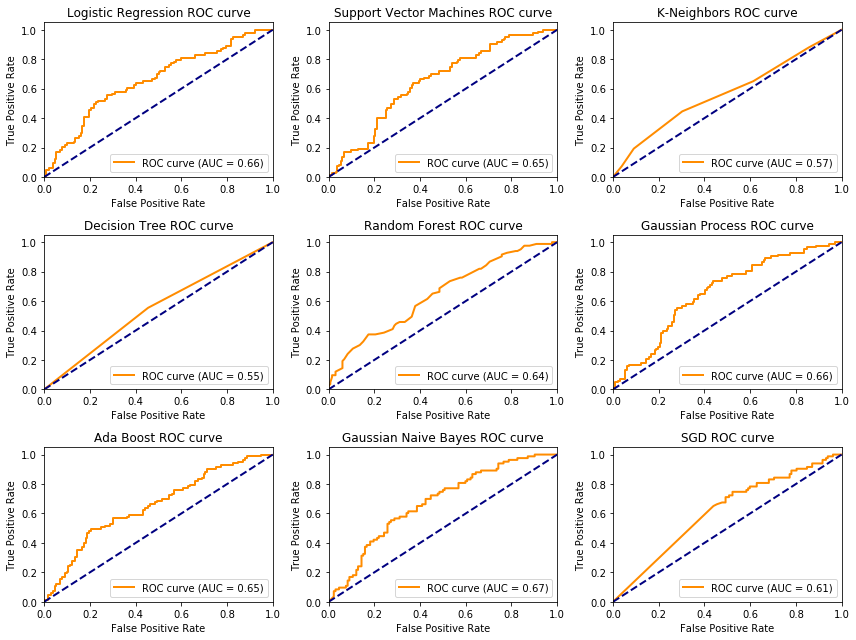

In [161]:
plt.figure(figsize=(12,9))
for i in range(1,10):
    fpr, tpr, thresholds = roc_curve(test_y, probabilities[names[i-1]], pos_label="Sí")
    roc_auc = auc(fpr, tpr)
    plt.subplot(int(str(33)+str(i)))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(names[i-1]+" ROC curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
plt.show()

Hyperparameter selection

For each model and fixed test data I tried different hyperparameters. For example:
* Gaussian Process- Tried different kernels (RBF, WhiteKernel, DotProduct, Matern, RationalQuadratic). Final selection: Matern.

I could have used a cross-validation hyperparameter selection but it took too long in my computer and I achieved quite nice results by manual tunning.
The maximum AUC that I obtained was over 0.71-0.72 with Support Vector Machines or Gaussian Process classifier. The final model:

In [162]:
model = SVC(probability=True)
model.fit(train_X, train_y)
test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
test_yhat = model.predict(test_X)

**2. Check if they satisfy the proposed fairness criteria.**

Our fairness criteria is equality of error rates. So, we will inspect the confusion matrix for each of our groups and focus on the cells corresponding to type I errors (false positives) and type II errors (false negatives).

Here, we use the default threshold provided by sklearn (0.5) to classify instances into recividists/non-recividists. 

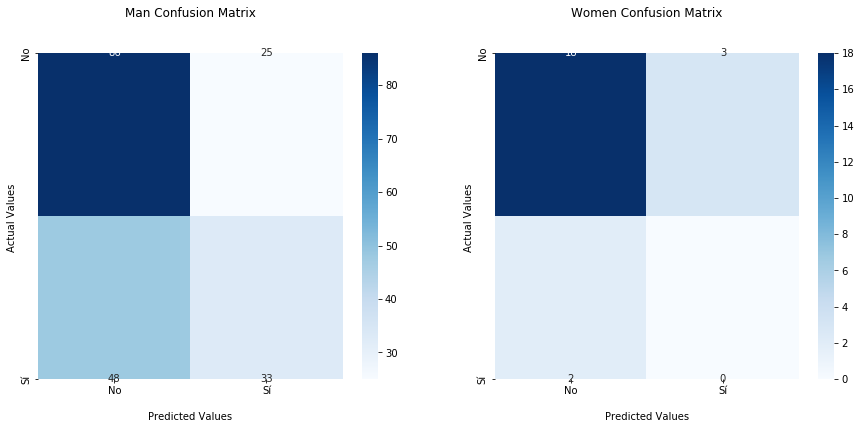

In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


#Generate the confusion matrix
test_yhat_men =  test_yhat[test_X["V1_sexe_Home"]==1]
test_y_men =  test_y[test_X["V1_sexe_Home"]==1]
cf_matrix_men = confusion_matrix(test_y_men, test_yhat_men)

test_yhat_women =  test_yhat[test_X["V1_sexe_Dona"]==1]
test_y_women =  test_y[test_X["V1_sexe_Dona"]==1]
cf_matrix_women = confusion_matrix(test_y_women, test_yhat_women)

fig, ax = plt.subplots(1,2, figsize=(15, 6))

sns.heatmap(cf_matrix_men, annot=True, cmap='Blues', ax = ax[0])

ax[0].set_title('Man Confusion Matrix\n\n');
ax[0].set_xlabel('\nPredicted Values')
ax[0].set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax[0].xaxis.set_ticklabels(['No','Sí'])
ax[0].yaxis.set_ticklabels(['No','Sí'])

sns.heatmap(cf_matrix_women, annot=True, cmap='Blues', ax = ax[1])

ax[1].set_title('Women Confusion Matrix\n\n');
ax[1].set_xlabel('\nPredicted Values')
ax[1].set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax[1].xaxis.set_ticklabels(['No','Sí'])
ax[1].yaxis.set_ticklabels(['No','Sí'])

## Display the visualization of the Confusion Matrix.
plt.show()

As the number of samples per group is not balanced, we can take a look at the false positive/negative rates for each of the groups to get a better idea of our fairness criteria.

In [164]:
for name, model in zip(names, models):
    print("=================================================================")
    print("              Fairness Analsis for {}              ".format(name))
    print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)

    FP = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat=='Sí')])
    TP = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat=='Sí')])
    FN = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat=='No')])
    TN = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat=='No')])

    cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
    FPR_man = FP / (FP+TN)
    FNR_man = FN / (FN+TP)

    FP = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat=='Sí')])
    TP = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat=='Sí')])
    FN = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat=='No')])
    TN = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat=='No')])

    cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
    FPR_women = FP / (FP+TN)
    FNR_women = FN / (FN+TP)

    index = ["Men", "Women"]
    metrics = ["FPR", "FNR"]
    data = [[FPR_man,FNR_man], [FPR_women, FNR_women]]
    display(pd.DataFrame(data, index=index, columns = metrics))

              Fairness Analsis for Logistic Regression              


,FPR,FNR
Men,0.243243,0.481481
Women,0.190476,1.000000


              Fairness Analsis for Support Vector Machines              


,FPR,FNR
Men,0.225225,0.592593
Women,0.142857,1.000000


              Fairness Analsis for K-Neighbors              


,FPR,FNR
Men,0.306306,0.54321
Women,0.285714,1.00000


              Fairness Analsis for Decision Tree              


,FPR,FNR
Men,0.441441,0.432099
Women,0.523810,0.500000


              Fairness Analsis for Random Forest              


,FPR,FNR
Men,0.360360,0.481481
Women,0.238095,0.500000


              Fairness Analsis for Gaussian Process              


,FPR,FNR
Men,0.243243,0.580247
Women,0.190476,1.000000


              Fairness Analsis for Ada Boost              


,FPR,FNR
Men,0.297297,0.469136
Women,0.142857,1.000000


              Fairness Analsis for Gaussian Naive Bayes              


,FPR,FNR
Men,0.342342,0.432099
Women,0.095238,0.500000


              Fairness Analsis for SGD              


,FPR,FNR
Men,0.018018,0.91358
Women,0.000000,1.00000


SVMs and Gaussian Process Classifiers are the best in terms of fairness.

In [165]:
for name, model in zip(names, models):
    print("=================================================================")
    print("              Fairness Analsis for {}              ".format(name))
    print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)
    
    FP = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(test_yhat=='Sí')])
    TP = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(test_yhat=='Sí')])
    FN = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(test_yhat=='No')])
    TN = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(test_yhat=='No')])

    cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
    FPR_spain = FP / (FP+TN)
    FNR_spain = FN / (FN+TP)

    FP = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(test_yhat=='Sí')])
    TP = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(test_yhat=='Sí')])
    FN = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(test_yhat=='No')])
    TN = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(test_yhat=='No')])

    cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
    FPR_foreign = FP / (FP+TN)
    FNR_foreign = FN / (FN+TP)

    index = ["Spanish", "Foreigner"]
    metrics = ["FPR", "FNR"]
    data = [[FPR_spain,FNR_spain], [FPR_foreign, FNR_foreign]]
    display(pd.DataFrame(data, index=index, columns = metrics))

              Fairness Analsis for Logistic Regression              


,FPR,FNR
Spanish,0.144737,0.684211
Foreigner,0.357143,0.333333


              Fairness Analsis for Support Vector Machines              


,FPR,FNR
Spanish,0.157895,0.736842
Foreigner,0.285714,0.488889


              Fairness Analsis for K-Neighbors              


,FPR,FNR
Spanish,0.328947,0.684211
Foreigner,0.267857,0.444444


              Fairness Analsis for Decision Tree              


,FPR,FNR
Spanish,0.315789,0.500000
Foreigner,0.500000,0.333333


              Fairness Analsis for Random Forest              


,FPR,FNR
Spanish,0.236842,0.684211
Foreigner,0.410714,0.311111


              Fairness Analsis for Gaussian Process              


,FPR,FNR
Spanish,0.171053,0.736842
Foreigner,0.321429,0.466667


              Fairness Analsis for Ada Boost              


,FPR,FNR
Spanish,0.223684,0.631579
Foreigner,0.339286,0.355556


              Fairness Analsis for Gaussian Naive Bayes              


,FPR,FNR
Spanish,0.263158,0.552632
Foreigner,0.357143,0.333333


              Fairness Analsis for SGD              


,FPR,FNR
Spanish,0.105263,0.842105
Foreigner,0.232143,0.600000


In most of the protected groups, all the error rates are significantly different, specially the False Positive Rate (non-recividists predicted as recidivists). For gender, the ML model tends to have a higher error rate in men and for nationality the model has a higher FNR a lower FPR for spanish defendants. 

3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity.

For the purpose of simplicity, we disregard the fact that the positive outcome (recividism) is not favorable. We will anaylise the results in the light of the probability of recividating.

First, I will compute step by step the metrics for the best AUC model.

In [166]:
best_model = SVC(probability=True)
best_model.fit(train_X, train_y)
best_test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
best_test_yhat = model.predict(test_X)

* Demographic Parity

The probabilities of a positive outcome are equal for the two groups. Mathematically:
$$P(\hat{Y}=Yes|X\in G^+) \sim P(\hat{Y}=Yes|X\in G^-)$$

The probability of being predicted as recividist should be similar disregarding gender or origin.

Applying Bayes Theorem we have that:
$$P(\hat{Y}=Yes|X\in G^+) = \frac{P(\hat{Y}=Yes \land X\in G^+)}{P(X\in G^+)} = \frac{P(X\in G^+|\hat{Y}=Yes)P(\hat{Y}=Yes)}{P(X\in G^+)} $$

In [167]:
prob_men = len(test_X[test_X["V1_sexe_Home"]==1])/len(test_X)
prob_women = len(test_X[test_X["V1_sexe_Dona"]==1])/len(test_X)

prob_recid = len(test_X[test_yhat=='Sí'])/len(test_X)
prob_nonrecid = len(test_X[test_yhat=='No'])/len(test_X)

pred_recid = test_X[test_yhat=='Sí']

prob_men_given_pred_recid = len(pred_recid[pred_recid["V1_sexe_Home"]==1])/len(pred_recid)
prob_women_given_pred_recid = len(pred_recid[pred_recid["V1_sexe_Dona"]==1])/len(pred_recid)

#Applying bayes theorem...
prob_pred_recid_given_men = (prob_men_given_pred_recid*prob_recid)/prob_men
prob_pred_recid_given_women = (prob_women_given_pred_recid*prob_recid)/prob_women

print("Probability of being predicted recivid given that it is a man: {:.4}".format(prob_pred_recid_given_men))
print("Probability of being predicted recivid given that it is a woman: {:.4}".format(prob_pred_recid_given_women))


Probability of being predicted recivid given that it is a man: 0.224
Probability of being predicted recivid given that it is a woman: 0.08696


In [168]:
prob_spanish = len(test_X[test_X["V2_estranger_Espanyol"]==1])/len(test_X)
prob_foreigner = len(test_X[test_X["V2_estranger_Estranger"]==1])/len(test_X)

prob_spanish_given_pred_recid = len(pred_recid[pred_recid["V2_estranger_Espanyol"]==1])/len(pred_recid)
prob_foreigner_given_pred_recid = len(pred_recid[pred_recid["V2_estranger_Estranger"]==1])/len(pred_recid)

#Applying bayes theorem...
prob_pred_recid_given_spanish = (prob_spanish_given_pred_recid*prob_recid)/prob_spanish
prob_pred_recid_given_foreigner = (prob_foreigner_given_pred_recid*prob_recid)/prob_foreigner

print("Probability of being predicted recivid given that it is a spanish: {:.4}".format(prob_pred_recid_given_spanish))
print("Probability of being predicted recivid given that it is a foreigner: {:.4}".format(prob_pred_recid_given_foreigner))


Probability of being predicted recivid given that it is a spanish: 0.1228
Probability of being predicted recivid given that it is a foreigner: 0.3069


In both protected features, we encounter demographic disparity. There is a higher chance to be predicted as recividist given that you are a men or foreigner.

* Equal opportunity

$$P(\hat{Y}=Yes|Y=Yes, X\in G^+) \sim P(\hat{Y}=Yes|Y=Yes, X\in G^-)$$

Again, using Bayes Theorem...

$$P(\hat{Y}=Yes|Y=Yes, X\in G^+) =  \frac{P(\hat{Y}=Yes, Y=Yes, X\in G^+)}{P(Y=Yes, X\in G^+)}$$

In [169]:
prob_pred_recid_actual_recid_man = len(test_X[(test_y=='Sí')&(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')])/len(test_X)
prob_actual_recid_man = len(test_X[(test_y=='Sí')&(test_X["V1_sexe_Home"]==1)])/len(test_X)

prob_pred_recid_actual_recid_woman = len(test_X[(test_y=='Sí')&(test_X["V1_sexe_Dona"]==1)&(test_yhat=='Sí')])/len(test_X)
prob_actual_recid_woman = len(test_X[(test_y=='Sí')&(test_X["V1_sexe_Dona"]==1)])/len(test_X)

prob_pred_recid_given_actual_recid_man = prob_pred_recid_actual_recid_man / prob_actual_recid_man
prob_pred_recid_given_actual_recid_woman = prob_pred_recid_actual_recid_woman / prob_actual_recid_woman


print("Probability of being predicted recivid given that it is a true recividist man: {:.4}".format(prob_pred_recid_given_actual_recid_man))
print("Probability of being predicted recivid given that it is a true recividist woman: {:.4}".format(prob_pred_recid_given_actual_recid_woman))



Probability of being predicted recivid given that it is a true recividist man: 0.2963
Probability of being predicted recivid given that it is a true recividist woman: 0.0


In [170]:
prob_pred_recid_actual_recid_spanish = len(test_X[(test_y=='Sí')&(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='Sí')])/len(test_X)
prob_actual_recid_spanish = len(test_X[(test_y=='Sí')&(test_X["V2_estranger_Espanyol"]==1)])/len(test_X)

prob_pred_recid_actual_recid_foreigner = len(test_X[(test_y=='Sí')&(test_X["V2_estranger_Estranger"]==1)&(test_yhat=='Sí')])/len(test_X)
prob_actual_recid_foreigner = len(test_X[(test_y=='Sí')&(test_X["V2_estranger_Estranger"]==1)])/len(test_X)

prob_pred_recid_given_actual_recid_spanish = prob_pred_recid_actual_recid_spanish / prob_actual_recid_spanish
prob_pred_recid_given_actual_recid_foreigner = prob_pred_recid_actual_recid_foreigner / prob_actual_recid_foreigner


print("Probability of being predicted recivid given that it is a true recividist spanish: {:.4}".format(prob_pred_recid_given_actual_recid_spanish))
print("Probability of being predicted recivid given that it is a true recividist foreigner: {:.4}".format(prob_pred_recid_given_actual_recid_foreigner))



Probability of being predicted recivid given that it is a true recividist spanish: 0.1579
Probability of being predicted recivid given that it is a true recividist foreigner: 0.4


Again, there is no equal opportunity between groups as the difference between scores is significant.

* Equalized odds
$$P(\hat{Y}=Yes|Y=Yes, X\in G^+) \sim P(\hat{Y}=Yes|Y=Yes, X\in G^-)$$
$$P(\hat{Y}=Yes|Y=No, X\in G^+) \sim P(\hat{Y}=Yes|Y=No, X\in G^-)$$

We have already confirmed that there is no equalized odds as the first condition is already violated (no equal opportunity). For completeness, let's compute the second condition:
$$P(\hat{Y}=Yes|Y=No, X\in G^+) =  \frac{P(\hat{Y}=Yes, Y=No, X\in G^+)}{P(Y=No, X\in G^+)}$$

In [171]:
prob_pred_recid_actual_notrecid_man = len(test_X[(test_y=='No')&(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')])/len(test_X)
prob_actual_notrecid_man = len(test_X[(test_y=='No')&(test_X["V1_sexe_Home"]==1)])/len(test_X)

prob_pred_recid_actual_notrecid_woman = len(test_X[(test_y=='No')&(test_X["V1_sexe_Dona"]==1)&(test_yhat=='Sí')])/len(test_X)
prob_actual_notrecid_woman = len(test_X[(test_y=='No')&(test_X["V1_sexe_Dona"]==1)])/len(test_X)

prob_pred_recid_given_actual_notrecid_man = prob_pred_recid_actual_notrecid_man / prob_actual_notrecid_man
prob_pred_recid_given_actual_notrecid_woman = prob_pred_recid_actual_notrecid_woman / prob_actual_notrecid_woman


print("Probability of being predicted recivid given that it is a non-recividist man: {:.4}".format(prob_pred_recid_given_actual_notrecid_man))
print("Probability of being predicted recivid given that it is a non-recividist woman: {:.4}".format(prob_pred_recid_given_actual_notrecid_woman))



Probability of being predicted recivid given that it is a non-recividist man: 0.1712
Probability of being predicted recivid given that it is a non-recividist woman: 0.09524


In [172]:
prob_pred_recid_actual_notrecid_spanish = len(test_X[(test_y=='No')&(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='Sí')])/len(test_X)
prob_actual_notrecid_spanish = len(test_X[(test_y=='No')&(test_X["V2_estranger_Espanyol"]==1)])/len(test_X)

prob_pred_recid_actual_notrecid_foreigner = len(test_X[(test_y=='No')&(test_X["V2_estranger_Estranger"]==1)&(test_yhat=='Sí')])/len(test_X)
prob_actual_notrecid_foreigner = len(test_X[(test_y=='No')&(test_X["V2_estranger_Estranger"]==1)])/len(test_X)

prob_pred_recid_given_actual_notrecid_spanish = prob_pred_recid_actual_notrecid_spanish / prob_actual_notrecid_spanish
prob_pred_recid_given_actual_notrecid_foreigner = prob_pred_recid_actual_notrecid_foreigner / prob_actual_notrecid_foreigner


print("Probability of being predicted recivid given that it is a non-recividist spanish: {:.4}".format(prob_pred_recid_given_actual_notrecid_spanish))
print("Probability of being predicted recivid given that it is a non-recividist foreigner: {:.4}".format(prob_pred_recid_given_actual_notrecid_foreigner))



Probability of being predicted recivid given that it is a non-recividist spanish: 0.1053
Probability of being predicted recivid given that it is a non-recividist foreigner: 0.2321


Both conditions are significantly violated, so we assess that the equalized odds constraint is violated.

* Conditional demographic parity

Total number of predicted not recividists:
$$\hat{n}^{\bar{recid}} = \hat{n}^\bar{recid}_{G^+} + \hat{n}^\bar{recid}_{G^-}$$ 
Total number of predicted recividists:
$$\hat{n}^{recid} = \hat{n}^{recid}_{G^+} + \hat{n}^{recid}_{G^-}$$ 
Demographic disparity for group G^+:
$$DD_{G^+} = \frac{\hat{n}^\bar{recid}_{G^+}}{\hat{n}^{\bar{recid}}} - \frac{\hat{n}^{recid}_{G^+}}{\hat{n}^{recid}}$$
Conditional demographic disparity:
$$CDD = \frac{1}{n}*\sum_i n_i * DD_i$$ where $n$ is the total number of observations and $n_i$ is the number of observations per subgroup i.

*The CDD metric gives a single measure for all of the disparities found in the subgroups defined by an attribute of a dataset by averaging them. **Positive values** indicate there is a demographic disparity as facet d or subgroup has a greater proportion of the rejected outcomes in the dataset than of the accepted outcomes. The higher the value the less favored the facet and the greater the disparity. **Negative values** indicate there is not a demographic disparity as facet d or subgroup has a larger proportion of the accepted outcomes in the dataset than of the rejected outcomes. The lower the value the more favored the facet.*

Reference: https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-cddl.html

In [173]:
n1 = test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='No')].shape[0]
n2 = test_yhat[(test_X["V1_sexe_Home"]==0)&(test_yhat=='No')].shape[0]
n3 = test_yhat[(test_yhat=='No')].shape[0]
assert(n1+n2==n3)
n4 = test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')].shape[0]
n5 = test_yhat[(test_X["V1_sexe_Home"]==0)&(test_yhat=='Sí')].shape[0]
n6 = test_yhat[(test_yhat=='Sí')].shape[0]
assert(n4+n5==n6)
DD_men = n1/n3 - n4/n6
DD_women = n2/n3 - n5/n6
n = len(test_yhat)
n_men = len(test_yhat[test_X["V1_sexe_Home"]==1])
n_women = len(test_yhat[test_X["V1_sexe_Home"]==0])

CDD = (1/n)*(n_men*DD_men + n_women*DD_women)
CDD


-0.062164462684298566

There is no demographic disparity, althought the value is quite close to 0.

In [174]:
n1 = test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='No')].shape[0]
n2 = test_yhat[(test_X["V2_estranger_Espanyol"]==0)&(test_yhat=='No')].shape[0]
n3 = test_yhat[(test_yhat=='No')].shape[0]
assert(n1+n2==n3)
n4 = test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='Sí')].shape[0]
n5 = test_yhat[(test_X["V2_estranger_Espanyol"]==0)&(test_yhat=='Sí')].shape[0]
n6 = test_yhat[(test_yhat=='Sí')].shape[0]
assert(n4+n5==n6)
DD_spanish = n1/n3 - n4/n6
DD_foreign = n2/n3 - n5/n6

n = len(test_yhat)
n_spanish = len(test_yhat[test_X["V2_estranger_Espanyol"]==1])
n_foreign = len(test_yhat[test_X["V2_estranger_Espanyol"]==0])

CDD = (1/n)*(n_spanish*DD_spanish + n_foreign*DD_foreign)
CDD


0.016756345949232414

There is demographic disparity, althought the value is quite close to 0.

**Comparison**

In this section, I conduct a fairness analysis for each of the ML models. I selected a threshold of .05 to assess if the proabilities for each of the groups are close enough or significantly different.

In [175]:
metrics = {name:{} for name in names}
LOGS=False
fairness_threshold = 0.05
for model, name in zip(models, names):
#model = SVC(probability=True)
    if LOGS: print("=================================================================")
    if LOGS: print("              Fairness Analsis for {}              ".format(name))
    if LOGS: print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)

    prob_men = len(test_X[test_X["V1_sexe_Home"]==1])/len(test_X)
    prob_women = len(test_X[test_X["V1_sexe_Dona"]==1])/len(test_X)

    prob_recid = len(test_X[test_yhat=='Sí'])/len(test_X)
    prob_nonrecid = len(test_X[test_yhat=='No'])/len(test_X)

    pred_recid = test_X[test_yhat=='Sí']

    prob_men_given_pred_recid = len(pred_recid[pred_recid["V1_sexe_Home"]==1])/len(pred_recid)
    prob_women_given_pred_recid = len(pred_recid[pred_recid["V1_sexe_Dona"]==1])/len(pred_recid)

    #Applying bayes theorem...
    prob_pred_recid_given_men = (prob_men_given_pred_recid*prob_recid)/prob_men
    prob_pred_recid_given_women = (prob_women_given_pred_recid*prob_recid)/prob_women

    if LOGS: print("Probability of being predicted recivid given that it is a man: {:.4}".format(prob_pred_recid_given_men))
    if LOGS: print("Probability of being predicted recivid given that it is a woman: {:.4}".format(prob_pred_recid_given_women))
    demographic_parity_gap = abs(prob_pred_recid_given_men - prob_pred_recid_given_women)
    if demographic_parity_gap < fairness_threshold:
        if LOGS: print("There is demographic parity")
        metrics[name]["Demographic Parity"]=True
    else: 
        if LOGS: print("There is no demographic parity")
        metrics[name]["Demographic Parity"]=False

    prob_pred_recid_actual_recid_man = len(test_X[(test_y=='Sí')&(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')])/len(test_X)
    prob_actual_recid_man = len(test_X[(test_y=='Sí')&(test_X["V1_sexe_Home"]==1)])/len(test_X)

    prob_pred_recid_actual_recid_woman = len(test_X[(test_y=='Sí')&(test_X["V1_sexe_Dona"]==1)&(test_yhat=='Sí')])/len(test_X)
    prob_actual_recid_woman = len(test_X[(test_y=='Sí')&(test_X["V1_sexe_Dona"]==1)])/len(test_X)

    prob_pred_recid_given_actual_recid_man = prob_pred_recid_actual_recid_man / prob_actual_recid_man
    prob_pred_recid_given_actual_recid_woman = prob_pred_recid_actual_recid_woman / prob_actual_recid_woman

    if LOGS: print()
    if LOGS: print("Probability of being predicted recivid given that it is a true recividist man: {:.4}".format(prob_pred_recid_given_actual_recid_man))
    if LOGS: print("Probability of being predicted recivid given that it is a true recividist woman: {:.4}".format(prob_pred_recid_given_actual_recid_woman))
    equal_opp_gap = abs(prob_pred_recid_given_actual_recid_man - prob_pred_recid_given_actual_recid_woman)
    if equal_opp_gap < fairness_threshold:
        if LOGS: print("There is equal opportunity")
        metrics[name]["Equal Opportunity"]=True
    else: 
        if LOGS: print("There is no equal opportunity")
        metrics[name]["Equal Opportunity"]=False

    prob_pred_recid_actual_notrecid_man = len(test_X[(test_y=='No')&(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')])/len(test_X)
    prob_actual_notrecid_man = len(test_X[(test_y=='No')&(test_X["V1_sexe_Home"]==1)])/len(test_X)

    prob_pred_recid_actual_notrecid_woman = len(test_X[(test_y=='No')&(test_X["V1_sexe_Dona"]==1)&(test_yhat=='Sí')])/len(test_X)
    prob_actual_notrecid_woman = len(test_X[(test_y=='No')&(test_X["V1_sexe_Dona"]==1)])/len(test_X)

    prob_pred_recid_given_actual_notrecid_man = prob_pred_recid_actual_notrecid_man / prob_actual_notrecid_man
    prob_pred_recid_given_actual_notrecid_woman = prob_pred_recid_actual_notrecid_woman / prob_actual_notrecid_woman

    if LOGS: print()
    if LOGS: print("Probability of being predicted recivid given that it is a non-recividist man: {:.4}".format(prob_pred_recid_given_actual_notrecid_man))
    if LOGS: print("Probability of being predicted recivid given that it is a non-recividist woman: {:.4}".format(prob_pred_recid_given_actual_notrecid_woman))
    nequal_opp_gap = abs(prob_pred_recid_given_actual_notrecid_man - prob_pred_recid_given_actual_notrecid_woman)
    if (nequal_opp_gap < fairness_threshold) and (equal_opp_gap<fairness_threshold):
        if LOGS: print("There is equalized odds")
        metrics[name]["Equalized Odds"]=True
    else: 
        if LOGS: print("There is no equalized odds")
        metrics[name]["Equalized Odds"]=True

    n1 = test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='No')].shape[0]
    n2 = test_yhat[(test_X["V1_sexe_Home"]==0)&(test_yhat=='No')].shape[0]
    n3 = test_yhat[(test_yhat=='No')].shape[0]
    assert(n1+n2==n3)
    n4 = test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')].shape[0]
    n5 = test_yhat[(test_X["V1_sexe_Home"]==0)&(test_yhat=='Sí')].shape[0]
    n6 = test_yhat[(test_yhat=='Sí')].shape[0]
    assert(n4+n5==n6)
    DD_men = n1/n3 - n4/n6
    DD_women = n2/n3 - n5/n6
    n = len(test_yhat)
    n_men = len(test_yhat[test_X["V1_sexe_Home"]==1])
    n_women = len(test_yhat[test_X["V1_sexe_Home"]==0])

    CDD = (1/n)*(n_men*DD_men + n_women*DD_women)
    if LOGS: print()
    if CDD < 0:
        if LOGS: print("There is no conditional demographic disparity")
        metrics[name]["CDD"]=True
    else:
        if LOGS: print("There is conditional demographic disparity")
        metrics[name]["CDD"]=False
    if LOGS: print()


In [176]:
gender_metrics = pd.DataFrame(metrics).T
gender_metrics

,Demographic Parity,Equal Opportunity,Equalized Odds,CDD
Logistic Regression,False,False,True,True
Support Vector Machines,False,False,True,True
K-Neighbors,False,False,True,True
Decision Tree,False,False,True,True
Random Forest,False,True,True,True
Gaussian Process,False,False,True,True
Ada Boost,False,False,True,True
Gaussian Naive Bayes,False,False,True,True
SGD,False,False,True,True


In [177]:
metrics = {name:{} for name in names}
LOGS=False
fairness_threshold = 0.05
for model, name in zip(models, names):
#model = SVC(probability=True)
    if LOGS: print("=================================================================")
    if LOGS: print("              Fairness Analsis for {}              ".format(name))
    if LOGS: print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)

    prob_spanish = len(test_X[test_X["V2_estranger_Espanyol"]==1])/len(test_X)
    prob_foreigner = len(test_X[test_X["V2_estranger_Estranger"]==1])/len(test_X)

    prob_recid = len(test_X[test_yhat=='Sí'])/len(test_X)
    prob_nonrecid = len(test_X[test_yhat=='No'])/len(test_X)

    pred_recid = test_X[test_yhat=='Sí']

    prob_spanish_given_pred_recid = len(pred_recid[pred_recid["V2_estranger_Espanyol"]==1])/len(pred_recid)
    prob_foreigner_given_pred_recid = len(pred_recid[pred_recid["V2_estranger_Estranger"]==1])/len(pred_recid)

    #Applying bayes theorem...
    prob_pred_recid_given_spanish = (prob_spanish_given_pred_recid*prob_recid)/prob_spanish
    prob_pred_recid_given_foreigner = (prob_foreigner_given_pred_recid*prob_recid)/prob_foreigner

    if LOGS: print("Probability of being predicted recivid given that it is a spanish: {:.4}".format(prob_pred_recid_given_spanish))
    if LOGS: print("Probability of being predicted recivid given that it is a foreigner: {:.4}".format(prob_pred_recid_given_foreigner))
    demographic_parity_gap = abs(prob_pred_recid_given_spanish - prob_pred_recid_given_foreigner)
    if demographic_parity_gap < fairness_threshold:
        if LOGS: print("There is demographic parity")
        metrics[name]["Demographic Parity"]=True
    else: 
        if LOGS: print("There is no demographic parity")
        metrics[name]["Demographic Parity"]=False

    prob_pred_recid_actual_recid_spanish = len(test_X[(test_y=='Sí')&(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='Sí')])/len(test_X)
    prob_actual_recid_spanish = len(test_X[(test_y=='Sí')&(test_X["V2_estranger_Espanyol"]==1)])/len(test_X)

    prob_pred_recid_actual_recid_foreigner = len(test_X[(test_y=='Sí')&(test_X["V2_estranger_Estranger"]==1)&(test_yhat=='Sí')])/len(test_X)
    prob_actual_recid_foreigner = len(test_X[(test_y=='Sí')&(test_X["V2_estranger_Estranger"]==1)])/len(test_X)

    prob_pred_recid_given_actual_recid_spanish = prob_pred_recid_actual_recid_spanish / prob_actual_recid_spanish
    prob_pred_recid_given_actual_recid_foreigner = prob_pred_recid_actual_recid_foreigner / prob_actual_recid_foreigner

    if LOGS: print()
    if LOGS: print("Probability of being predicted recivid given that it is a true recividist spanish: {:.4}".format(prob_pred_recid_given_actual_recid_spanish))
    if LOGS: print("Probability of being predicted recivid given that it is a true recividist foreigner: {:.4}".format(prob_pred_recid_given_actual_recid_foreigner))
    equal_opp_gap = abs(prob_pred_recid_given_actual_recid_spanish - prob_pred_recid_given_actual_recid_foreigner)
    if equal_opp_gap < fairness_threshold:
        if LOGS: print("There is equal opportunity")
        metrics[name]["Equal Opportunity"]=True
    else: 
        if LOGS: print("There is no equal opportunity")
        metrics[name]["Equal Opportunity"]=False

    prob_pred_recid_actual_notrecid_spanish = len(test_X[(test_y=='No')&(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='Sí')])/len(test_X)
    prob_actual_notrecid_spanish = len(test_X[(test_y=='No')&(test_X["V2_estranger_Espanyol"]==1)])/len(test_X)

    prob_pred_recid_actual_notrecid_foreigner = len(test_X[(test_y=='No')&(test_X["V2_estranger_Estranger"]==1)&(test_yhat=='Sí')])/len(test_X)
    prob_actual_notrecid_foreigner = len(test_X[(test_y=='No')&(test_X["V2_estranger_Estranger"]==1)])/len(test_X)

    prob_pred_recid_given_actual_notrecid_spanish = prob_pred_recid_actual_notrecid_spanish / prob_actual_notrecid_spanish
    prob_pred_recid_given_actual_notrecid_foreigner = prob_pred_recid_actual_notrecid_foreigner / prob_actual_notrecid_foreigner

    if LOGS: print()
    if LOGS: print("Probability of being predicted recivid given that it is a non-recividist spanish: {:.4}".format(prob_pred_recid_given_actual_notrecid_spanish))
    if LOGS: print("Probability of being predicted recivid given that it is a non-recividist foreigner: {:.4}".format(prob_pred_recid_given_actual_notrecid_foreigner))
    nequal_opp_gap = abs(prob_pred_recid_given_actual_notrecid_spanish - prob_pred_recid_given_actual_notrecid_foreigner)
    if (nequal_opp_gap < fairness_threshold) and (equal_opp_gap<fairness_threshold):
        if LOGS: print("There is equalized odds")
        metrics[name]["Equalized Odds"]=True
    else: 
        if LOGS: print("There is no equalized odds")
        metrics[name]["Equalized Odds"]=True

    n1 = test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='No')].shape[0]
    n2 = test_yhat[(test_X["V2_estranger_Espanyol"]==0)&(test_yhat=='No')].shape[0]
    n3 = test_yhat[(test_yhat=='No')].shape[0]
    assert(n1+n2==n3)
    n4 = test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='Sí')].shape[0]
    n5 = test_yhat[(test_X["V2_estranger_Espanyol"]==0)&(test_yhat=='Sí')].shape[0]
    n6 = test_yhat[(test_yhat=='Sí')].shape[0]
    assert(n4+n5==n6)
    DD_spanish = n1/n3 - n4/n6
    DD_foreigner = n2/n3 - n5/n6
    n = len(test_yhat)
    n_spanish = len(test_yhat[test_X["V2_estranger_Espanyol"]==1])
    n_foreigner = len(test_yhat[test_X["V2_estranger_Espanyol"]==0])

    CDD = (1/n)*(n_spanish*DD_spanish + n_foreigner*DD_foreigner)
    if LOGS: print()
    if CDD < 0:
        if LOGS: print("There is no conditional demographic disparity")
        metrics[name]["CDD"]=True
    else:
        if LOGS: print("There is conditional demographic disparity")
        metrics[name]["CDD"]=False
    if LOGS: print()


In [178]:
origin_metrics = pd.DataFrame(metrics).T
origin_metrics

,Demographic Parity,Equal Opportunity,Equalized Odds,CDD
Logistic Regression,False,False,True,False
Support Vector Machines,False,False,True,False
K-Neighbors,False,False,True,False
Decision Tree,False,False,True,False
Random Forest,False,False,True,False
Gaussian Process,False,False,True,False
Ada Boost,False,False,True,False
Gaussian Naive Bayes,False,False,True,False
SGD,False,False,True,False


**Questions**
1. Is there a method that can achieve better predictive power than human experts?

The technical answer to this question does not have a straightforward answer because of one reasons: predictions by humans as presented in the data come in three categories (Baixa, Moderada and Alta) while the output of ML models is a yes/no.
To overcome this issue, we can classify instances with 'Alt' risk as predicted recividists, people with 'Baix' risk as non-recividists, and people with 'Moderat' risk randomly into the two categories. This would be a feasible mapping from 3 to 2 categories.

In this case, the accuracy of the best ML model (SVM) is similar to the accuracy of human experts. However, the random component in the data splitting, the ML itself and the 2-category human assigment makes it difficult to tell.

To sum up, I would say that it can be a case that we find a model that has better predictive power than human experts because it can consider a great amount of data and hidden patterns that humans are unable to identify. However, in this specific problem trained human criteria can generate also good results.


In [179]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, best_test_yhat)

0.627906976744186

In [180]:
def human_to_risk(col):
    if col=='Alta':
        return 'Sí'
    if col =='Baixa':
        return 'No'
    else:
        if np.random.uniform() < 0.5:
            return 'Sí'
        else:
            return 'No'
        
test_y_human = test['V56_@R1_resum_risc_global_reverse'].map(human_to_risk)
accuracy_score(test_y, test_y_human)

0.6186046511627907

2- Is this method better than human experts in terms of fairness?

It could be. In our case, the difference of error rates between groups is nearly the same, so we could say that the ML model is more fair. It is true that ML models are very good in encoding and reproducing data bias that can lead to discrimination, but it also happens that human experts also have their own biases. The main threat of systematically using unfair ML models is the scalability power, i.e., this models can affect more people than if they were just assessed by human experts.

In [181]:
#human fairness
FP = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(test_y_human=='Sí')])
TP = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(test_y_human=='Sí')])
FN = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(test_y_human=='No')])
TN = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(test_y_human=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
FPR_spain = FP / (FP+TN)
FNR_spain = FN / (FN+TP)

FP = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(test_y_human=='Sí')])
TP = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(test_y_human=='Sí')])
FN = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(test_y_human=='No')])
TN = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(test_y_human=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
FPR_foreign = FP / (FP+TN)
FNR_foreign = FN / (FN+TP)

index = ["Spanish", "Foreigner"]
metrics = ["FPR", "FNR"]
data = [[FPR_spain,FNR_spain], [FPR_foreign, FNR_foreign]]
display(pd.DataFrame(data, index=index, columns = metrics))

,FPR,FNR
Spanish,0.328947,0.526316
Foreigner,0.410714,0.311111


In [182]:
#best predictor fairness
FP = len(best_test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(best_test_yhat=='Sí')])
TP = len(best_test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(best_test_yhat=='Sí')])
FN = len(best_test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(best_test_yhat=='No')])
TN = len(best_test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(best_test_yhat=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
FPR_spain = FP / (FP+TN)
FNR_spain = FN / (FN+TP)

FP = len(best_test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(best_test_yhat=='Sí')])
TP = len(best_test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(best_test_yhat=='Sí')])
FN = len(best_test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(best_test_yhat=='No')])
TN = len(best_test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(best_test_yhat=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
FPR_foreign = FP / (FP+TN)
FNR_foreign = FN / (FN+TP)

index = ["Spanish", "Foreigner"]
metrics = ["FPR", "FNR"]
data = [[FPR_spain,FNR_spain], [FPR_foreign, FNR_foreign]]
display(pd.DataFrame(data, index=index, columns = metrics))

,FPR,FNR
Spanish,0.105263,0.842105
Foreigner,0.232143,0.600000


3. Which is the most suited fairness criterium for this problem? Why?

In this problem we are assessing the probability of recividism, this is, committing a new crime. Before answering this question it is worth thinking about the consequences of each outcome. What happens when a person is predicted as recividist? Will he/she be subject to a higher surveilance in the future? Will he/she spend more time in prison? All this questions are tightly related to the consequences of incorrect predictions:
* Predicting a recividist as non recividit (false negative) can lead to freeing a criminal that can potentially steal, kill someone, etc or any crime.
* Predicting a non-recividist as recividist (false postive) can lead to a innocent person to have its freedom compromised.

I believe that there is no universal fairness criterium that can suit this problem. There are other variables that we should consider before giving more importance to one or other metric. The consecuences of a false positive serial killer is sustantially different than the consecuences of emprisoning a pickpocket. 

4. What are your conclusion about the use of a ML model to predict recividism?

I think that we encounter advantages and disadvantages. ML models can be biased, but also human predictions. The main disadvantage of ML is that it can afect a larger span of people, and with the same systematic bias. However, althought there are many social biases, humans have their own opinion that affects the predictions. Moreover, as seen in this practice, ML does not improve significantly the prediction with respect to human criteria, both in performance and fairness. The main advantage of ML is automatization, but the final result should anyhow be supervised by a human.For this reason, I conclude that ML is not needed in this problem. 

# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: equalized base rates (EBR). Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

$$P(y|x(f')=g_i) = \frac{P(y, x(f')=g_i)}{P(x(f')=g_i)}$$

First, I tried to follow the mathematical description provided. However, the quantity $P(y|x(f')=g_i)$ is a probability distribution rather than a value and as a result $|S_i|$ is not a scalar number. So, I decided to fix $y=0$ to obtain a value.

In [183]:
prob_women = len(train[train['V1_sexe']=='Dona'])/len(train)
women_recid = train[(train['V1_sexe']=='Dona') & (train['V115_reincidencia_2015']=='Sí')]
prob_women_recid = len(women_recid)/len(train)
prob_recid_given_woman = prob_women_recid /  prob_women

prob_men = len(train[train['V1_sexe']=='Home'])/len(train)
men_recid = train[(train['V1_sexe']=='Home') & (train['V115_reincidencia_2015']=='Sí')]
prob_men_recid = len(men_recid)/len(train)
prob_recid_given_men = prob_men_recid /  prob_men

Si_ref_women = prob_women*(prob_recid_given_woman-prob_recid_given_men)
print("S_i women: {:.4}".format(Si_ref_women))
Si_ref_men = prob_men*(prob_recid_given_men- prob_recid_given_woman)
print("S_i men: {:.4}".format(Si_ref_men))

S_i women: -0.0207
S_i men: 0.1401


As expected, the result is not an integer number and if rounded, the approximation would be 0. Consequently, the number of positive or negative condition samples that we should add/remove is 0, which is not correct as it does not yield equal base rates. 

Second, I decided to focus on obtaining $P(x(f')=g_i) = P(x(f')=g_{ref})$ with a regular oversampling procedure. In the end, we just want to obtain the same number of men and women, and the same number of spanish and foreigners.


In [184]:
#!pip install imblearn

In [185]:
train_Xy_2 = pd.get_dummies(train[factors+['V115_reincidencia_2015']])

In [186]:
cols_without_gender = train_Xy_2.columns.drop('V1_sexe_Home')
cols_without_gender = cols_without_gender.drop('V1_sexe_Dona')
cols_without_nationality = train_Xy_2.columns.drop('V2_estranger_Estranger')
cols_without_nationality = cols_without_nationality.drop('V2_estranger_Espanyol')

print("Number of women before: {}".format(len(train_Xy_2[train_Xy_2['V1_sexe_Home']==0])))

Number of women before: 56


In [187]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X_resampled, y_resampled = RandomOverSampler().fit_resample(train_Xy_2[cols_without_gender], train_Xy_2['V1_sexe_Home'])
print(sorted(Counter(y_resampled).items()))

train_X_3 = X_resampled.copy()
a = pd.Series(y_resampled.values, index=train_X_3.index, dtype=bool)
train_X_3['V1_sexe_Home'] =a.astype(int)
train_X_3['V1_sexe_Dona'] = (~a).astype(int)
print()
print("Number of women after: {}".format(train_X_3['V1_sexe_Home'].sum()))
train_X_4 = train_X_3.drop('V115_reincidencia_2015_Sí', axis=1)
train_X_4 = train_X_4.drop('V115_reincidencia_2015_No', axis=1)
train_y_4 = train_X_3["V115_reincidencia_2015_Sí"]
train_X_4 = train_X_4[test_X.columns]

[(0, 379), (1, 379)]

Number of women after: 379


Now, we have the same probability of men and women in our dataset. Let's fit again the SVM and obtain the performance and fairness metrics.

In [188]:
model_EBR = SVC(probability=True)
model_EBR.fit(train_X_4, train_y_4)
test_prob_EBR = model.predict_proba(test_X)[:,1] #probability of recividate
test_yhat_EBR = model.predict(test_X)
#test_yhat_EBR = pd.Series(test_yhat_EBR, index=test_y.index).map(lambda x: 'Sí' if x==1 else 'No')


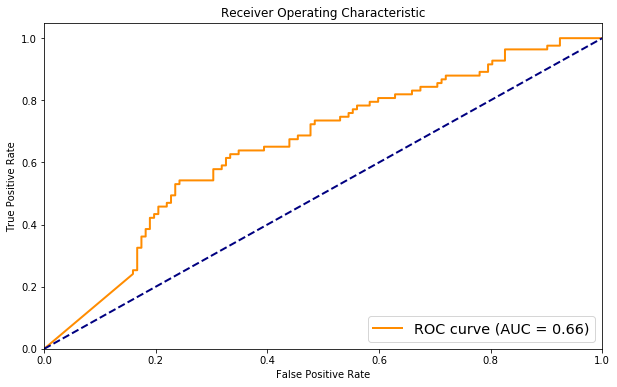

In [189]:
_ = draw_roc_curve(test_y, test_prob_EBR)

In [190]:
FP = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat_EBR=='Sí')])
TP = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat_EBR=='Sí')])
FN = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat_EBR=='No')])
TN = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat_EBR=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
FPR_man = FP / (FP+TN)
FNR_man = FN / (FN+TP)

FP = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat_EBR=='Sí')])
TP = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat_EBR=='Sí')])
FN = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat_EBR=='No')])
TN = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat_EBR=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
FPR_women = FP / (FP+TN)
FNR_women = FN / (FN+TP)

index = ["Men", "Women"]
metrics = ["FPR", "FNR"]
data = [[FPR_man,FNR_man], [FPR_women, FNR_women]]
display(pd.DataFrame(data, index=index, columns = metrics))

,FPR,FNR
Men,0.198198,0.604938
Women,0.095238,1.000000


This procedure reduces a bit the gender bias while achieving a quite good performance (lower than before, but still good).

1- Is the application of this mitigation method sufficient to guarantee fair outcomes?

Not really. This procedure of generating synthetic data produces that some samples have a higher weight in the model, specially when the underrepresented class is very small. EBR can help in some scenarios but as the authors explain, this method can have a negative impact in other features. For this reason, it is not a sufficient solution to guarantee fair outcomes. 

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

### Questions

1. Which are the top ten most important features of each model?

2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

(i)  human risk assessment score

It is not possible to apply explainability techniques as we do not have the scoring function that gives an output for new instances. Most of the python libraries require a prediction function. 

(ii) to the SAVRY baseline model

Similarly as in part (i) we cannot know how predictions are made as we do not have a predict function. The maximum that we can do is to inspect the correlation (that it is not the same as causation) of the SAVRY score and the rest of the predictors.

In [191]:
train.corr()['V60_SAVRY_total_score'].sort_values()[:10]

V9_edat_final_programa         -0.121558
V8_edat_fet                    -0.097544
V102_edat_reincidencia_2015    -0.085680
V29_durada_programa            -0.078111
V103_temps_reincidencia_2015   -0.057052
V28_temps_inici                -0.047431
id                             -0.018654
V118_edat_reincidencia_2013     0.021690
V116_rein_nombre_fets_2013      0.062838
V100_rein_nombre_fets_2015      0.071354
Name: V60_SAVRY_total_score, dtype: float64

(iii) to the best ML model

First, I used the permutation importance technique in order to assess feature importance. This technique suffles the data column by column and measures the impact that this randomness has into the prediction. The values with higher value are the most important features, and those towards the bottom matter least. Negative values indicate features that when shuffled increased performance, so they just add noise to the model.

Reference: https://www.kaggle.com/code/dansbecker/permutation-importance/tutorial

In [192]:
from sklearn.inspection import permutation_importance

model = SVC(probability=True)
model.fit(train_X, train_y)
test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
test_yhat = model.predict(test_X)

result = permutation_importance(model, test_X, test_y, n_repeats=10, random_state=42, n_jobs=2)


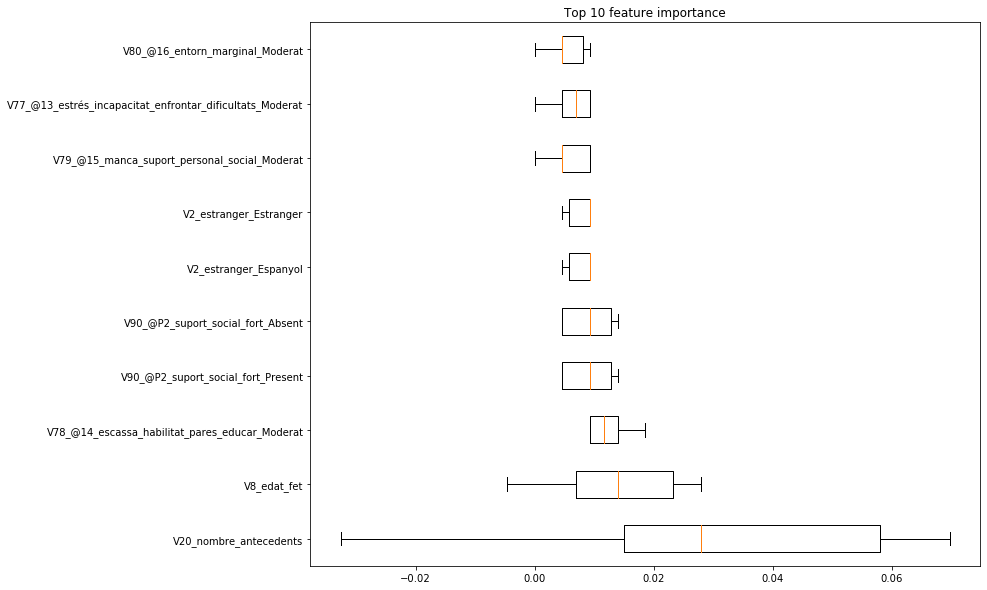

In [193]:
importances = result.importances_mean
order = np.argsort(importances)[::-1]
sorted_importances = result.importances[order]
sorted_features = test_X.columns[order]

top_10, top_10_order, top_10_names = sorted_importances[:10], order[:10], sorted_features[:10]
plt.figure(figsize=(12,10))
plt.subplot()
plt.title("Top 10 feature importance")
plt.boxplot(top_10.T, vert=False, labels = top_10_names)#, labels=factors[sorted_idx]);
plt.show()

Here, I inspect the feature importance after EBR.

In [194]:
from sklearn.inspection import permutation_importance


result = permutation_importance(model_EBR, test_X, test_y.map(lambda x: 1 if x=='Sí' else 0), n_repeats=10, random_state=42, n_jobs=2)


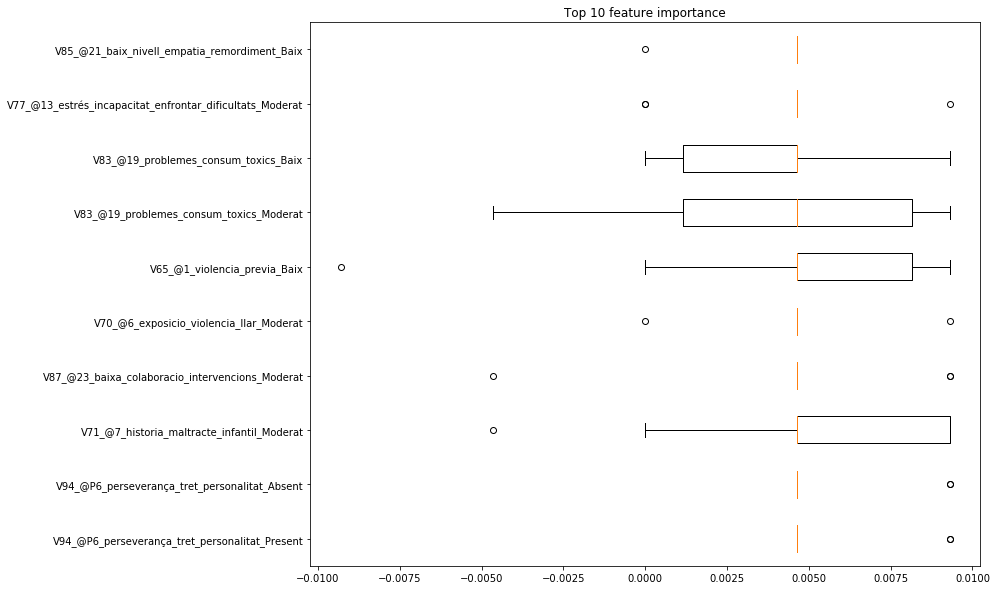

In [195]:
importances = result.importances_mean
order = np.argsort(importances)[::-1]
sorted_importances = result.importances[order]
sorted_features = test_X.columns[order]

top_10, top_10_order, top_10_names = sorted_importances[:10], order[:10], sorted_features[:10]
plt.figure(figsize=(12,10))
plt.subplot()
plt.title("Top 10 feature importance")
plt.boxplot(top_10.T, vert=False, labels = top_10_names)#, labels=factors[sorted_idx]);
plt.show()

Features differ in both models (no EBR and EBR).